$\tau_p\frac{dy(t)}{dt}=-y(t)+K_pu(t-\theta_p)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

In [3]:
# define process model(to generate process data) high order model
def process(y,t,n,u,Kp,taup):
    #arguments
    #y[n]=outputs
    #t=time
    #n=order of the system
    #u=input value
    #Kp=process gain
    #taup=process time constant
    
    # equations for higner order system
    dydt = np.zeros(n)
    # calculate derivative
    dydt[0]=(-y[0]+Kp*u)/(taup/n)
    for i in range(1,n):
        dydt[i]=(-y[i]+y[i-1])/(taup/n)
    return dydt
    
    

In [4]:
# define first-order plus dead-time approximation
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    # y = output
    # t = time
    # uf = input linear function(for time shift)
    # Km = model gain
    # taum = model time constant
    # thetam = model time constant
    # time-shift u
    try:
        if (t-thetam)<0:
            um=uf(0.0)
        else:
            um=uf(t-thetam)
    except:
        #print('Error with time extrapolation: '+str(t))
        um=0
    dydt = (-y + Km*um)/taum
    return dydt


In [5]:
# specify number of steps
ns = 40
# define time points
t = np.linspace(0,16,ns+1)
delta_t = t[1]-t[0]
# define input vector
u = np.zeros(ns+1)
u[5:] = 1.0
# create linear interpolation of the u data verus time
uf = interp1d(t,u)


In [8]:
# use the function or replace yp with real process date
def sim_process_data():
    # higher order process
    n = 10 # order
    Kp = 3.0 # gain
    taup = 5.0 # time constant
    # storage for predictions or data
    yp = np.zeros(ns+1)
    for i in range(1,ns+1):
        if i==1:
            yp0=np.zeros(n)
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process,yp0,ts,args=(n,u[i],Kp,taup))
        yp0 = y[-1]
        yp[i]=y[1][n-1]
    return yp

yp = sim_process_data()

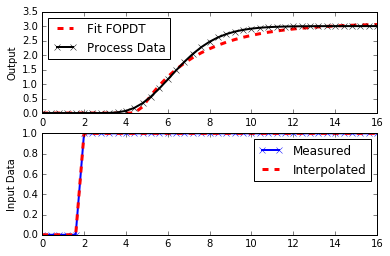

In [29]:
# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(Km,taum,thetam):
    # input arguments
    # Km
    # taum
    # thetam
    # storage for model values
    ym = np.zeros(ns+1)
    # initial condition
    ym[0]=0
    # loop through time steps
    for i in range(1,ns+1):
        ts = [delta_t*(i-1),delta_t*i]
        y1 = odeint(fopdt,ym[i-1],ts,args=(uf,Km,taum,thetam))
        ym[i] = y1[-1]
    return ym
# calculate model with updated parameters
Km = 3.1
taum = 2.7
thetam = 2.8
ym = sim_model(Km,taum,thetam)


# plot results
% matplotlib inline
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym,'r--',linewidth=3,label='Fit FOPDT')
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()